/opt/anaconda3/envs/python312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [60]:
class State(BaseModel):
    ## operator.add defines how to merge the lists. In this case, it is the 'extend' function of the List[str]
    messages: Annotated[List, add_messages]
    route: Optional[Literal["search_arxiv", "search_local_files"]] = None

class Router(BaseModel):
    reasoning: str = Field(
        "Step-by-step reasoning behind the classifaction"
    )
    classification: Literal["search_arxiv", "search_local_files"] = Field(
        description="The classification of user's input:"
        "'search_arxiv' for searching the arxiv"
        "'search_local_files' for searching the local files"
    )


def _extract_json(text: str) -> str:
    m = re.search(r"\{.*\}", text, flags=re.S)
    if not m:
        raise ValueError(f"Model did not return JSON: {text[:500]}")
    return m.group(0)

def classification_router(state: State) -> Command[Literal["search_arxiv","search_local_files","__end__"]]:
    # ## Deepseek-chat does not support function calling yet, so we use structured output parsing instead.
    # router = llm.with_structured_output(Router)

    user_text = state.messages[-1].content

    prompt = (
        'Return ONLY valid JSON like: {"reasoning":"...","classification":"search_arxiv"}.\n'
        'classification must be exactly one of: "search_arxiv" or "search_local_files".\n\n'
        f"User request: {user_text}"
    )

    print(state.messages[-1])
    router_result = llm.invoke([HumanMessage(content=prompt)])

    router_obj = Router.model_validate_json(_extract_json(router_result.content))


    print(f"classification_router is received state: {router_obj.classification}")

    # if router_result.classification == "search_arxiv":
    #     goto = "search_arxiv"
    # elif router_result.classification == "search_local_files":
    #     goto = "search_local_files"
    # else:
    #     raise Exception("Cannot classify")
    
    return Command(goto="assistant", update={"route": router_obj.classification})


def should_use_tools(state: State) -> Command[Literal["research_tools","__end__"]]:
    messages = state.messages
    last_message = messages[-1]

    goto = "__end__"

    if last_message.tool_calls:
        goto = "research_tools"
    else:
        goto = "__end__"

    return Command(goto=goto)


def research_agent(state: State) -> dict:
    msg = llm_with_tools.invoke(
        state.messages
    )
    return {"messages": [msg]}

# def search_arxiv(state: State) -> State:
#     '''
#         Searches the arxiv for relevant papers based on the user's query.
#     '''
#     msg = llm.invoke([HumanMessage(content="Searching arxiv for relevant papers...")])
#     return State(messages=[msg])

@tool
def search_local_files(**kwargs) -> str:
    '''
        Searches the local files for relevant papers based on the user's query.
    '''
    return f"[local] results for: {kwargs}"
    # msg = llm.invoke([HumanMessage(content="Searching local files for relevant papers...")])
    # return State(messages=[msg])


# # 3) assistant 节点：让模型决定要不要调用工具（有 tool_calls 就会被 tools_condition 捕捉）
# def assistant(state: State) -> dict:
#     # 可选：把 route 注入提示词，让模型更倾向调用某类工具
#     route_hint = f"Route: {state.route}\n" if state.route else ""
#     msg = llm_with_tools.invoke(
#         state.messages + [HumanMessage(content=route_hint + "Decide whether to call tools; if needed, call them.")]
#     )
#     return {"messages": [msg]}


arxiv_mcp = MultiServerMCPClient({
        "arxiv-mcp-server": {
            "transport": "stdio",
            "command": "uv",
            "args": [
                "tool",
                "run",
                "arxiv-mcp-server",
                "--storage-path", "output/arxiv"
            ]
        }
})



tools = await arxiv_mcp.get_tools()

tools += [search_local_files]

research_tools = ToolNode(tools)


# def node_p(state: State) -> State:
#     print(f"node P is received state: {state.messages}")
#     note = "P"
#     return State(messages=[note])


llm = init_chat_model(
    "deepseek-chat",
    temperature=0.0
)


llm_with_tools = llm.bind_tools(tools)

# llm = ChatLiteLLM(
#     model="deepseek/deepseek-chat", # Or any LiteLLM-supported model
#     streaming=False,
#     temperature=0.0
# )

In [76]:

from unittest import result
from pprint import pprint

builder = StateGraph(State)



# builder.add_node("classification_router", classification_router)
builder.add_node("research_agent", research_agent)
builder.add_node("should_use_tools", should_use_tools)
builder.add_node("research_tools", research_tools)

builder.add_edge(START, "research_agent")
builder.add_edge("research_agent", "should_use_tools")
builder.add_edge("research_tools", END)


# builder.add_node("search_arxiv", search_arxiv)
# builder.add_node("search_local_files", search_local_files)
# builder.add_edge("search_arxiv", END)


graph = builder.compile()

initital = State(messages=[HumanMessage(content="search 10 papers about graphene system from 2025-12-01 to today in the cond-mat categorie")])
result = await graph.ainvoke(initital)
pprint(result)

{'messages': [HumanMessage(content='search 10 papers about graphene system from 2025-12-01 to today in the cond-mat categorie', additional_kwargs={}, response_metadata={}, id='a2d1cfc9-9b7b-4ac3-af2a-da16a36fc837'),
              AIMessage(content="I'll search for recent graphene system papers in the condensed matter physics category from December 1, 2025 to today.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 146, 'prompt_tokens': 1534, 'total_tokens': 1680, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 1472}, 'prompt_cache_hit_tokens': 1472, 'prompt_cache_miss_tokens': 62}, 'model_provider': 'deepseek', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'b70c633c-3e49-4538-af2e-5c7367bb6aea', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019be61b-de45-7c71-95ad-115db11ae221-0', tool_calls=[{'name': 'search_papers', 'args'

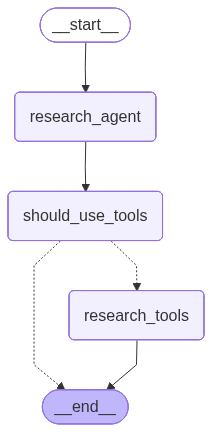

In [45]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [77]:
import json

print(result["messages"][-2])
with open("output/arxiv/arxiv_results.json", "w") as f:
    json.dump(json.loads(result["messages"][-1].content[0]["text"]),f, indent=4)



content="I'll search for recent graphene system papers in the condensed matter physics category from December 1, 2025 to today." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 146, 'prompt_tokens': 1534, 'total_tokens': 1680, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 1472}, 'prompt_cache_hit_tokens': 1472, 'prompt_cache_miss_tokens': 62}, 'model_provider': 'deepseek', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'b70c633c-3e49-4538-af2e-5c7367bb6aea', 'finish_reason': 'tool_calls', 'logprobs': None} id='lc_run--019be61b-de45-7c71-95ad-115db11ae221-0' tool_calls=[{'name': 'search_papers', 'args': {'query': 'graphene system', 'categories': ['cond-mat'], 'date_from': '2025-12-01', 'max_results': 10, 'sort_by': 'date'}, 'id': 'call_00_fKu8ZGx9Z8AM8afllDJh5izL', 'type': 'tool_call'}] invalid_tool_calls=[] usage_metadata={'input_tokens': 1

In [ ]:
tool = next(t for t in tools if t.name == "search_papers")  # 按你的实际工具名改
params = {
    "query": "graphene",
    "date_from": "2025-06-01",
    "date_to": "2026-01-21",
    "max_results": 10,
    # "categories": ["cond-mat.mtrl-sci"],  # 先注释掉验证
}


res = await tool.ainvoke(params)
print(res)

[{'type': 'text', 'text': '{\n  "total_results": 0,\n  "papers": []\n}', 'id': 'lc_65d4b27a-2e4f-44b4-bc24-79e127a1560b'}]


In [84]:
tool = next(t for t in tools if t.name == "search_papers")
# {'query': 'graphene system', 'categories': ['cond-mat'], 'date_from': '2025-12-01', 'max_results': 10, 'sort_by': 'date'}


print(await tool.ainvoke({"query": "graphene","date_from": "2025-12-01", "max_results": 5}))
print(await tool.ainvoke({'query': 'graphene', 'categories': ['cond-mat'], 'date_from': '2025-12-01', 'date_to': '2026-01-11', 'max_results': 100, 'sort_by': 'date'}))
# print(await tool.ainvoke({"query": "all:graphene", "max_results": 5}))

# # 直接在 notebook 新建一个 cell 跑
# tool = next(t for t in tools if t.name == "search_papers")
# print("name:", tool.name)
# print("description:", tool.description)

# args_schema = getattr(tool, "args_schema", None)
# print("args_schema:", args_schema)

# if args_schema is not None:
#     # pydantic v2
#     try:
#         import json
#         print(json.dumps(args_schema.model_json_schema(), indent=2, ensure_ascii=False))
#     except Exception as e:
#         print("failed to dump schema:", e)

[{'type': 'text', 'text': '{\n  "total_results": 0,\n  "papers": []\n}', 'id': 'lc_47133794-9638-4fbb-a9f9-0346c1c46295'}]
[{'type': 'text', 'text': '{\n  "total_results": 11,\n  "papers": [\n    {\n      "id": "2601.06509v1",\n      "title": "The role of ZnO/ZnS nanostructures decoration of Ni foam on the electrochemical energy storage process",\n      "authors": [\n        "Alessia Fischetti",\n        "Giacometta Mineo",\n        "Daniela Russo",\n        "Francesco Salutari",\n        "Claudio Lentini Campallegio",\n        "Elena Bruno",\n        "Jordi Arbiol",\n        "Giorgia Franz\\u00f2",\n        "Salvatore Mirabella",\n        "Vincenzina Strano",\n        "M. Chiara Spadaro"\n      ],\n      "abstract": "Low-cost and environmentally friendly electrochemical energy storage systems are crucial to address the increasing global energy demand. Nanomaterials can play a pivotal role in catalysing charge storage and/or exchange, still the underlying mechanism often remains poorly

In [1]:
import os
from dotenv import load_dotenv
load_dotenv("./local_env.env")
from IPython.display import display, Image

import re
import operator
from typing import List, Annotated, Literal, Optional
from pydantic import BaseModel, Field
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain.agents import create_agent
from langchain.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command
from langchain.tools import tool, ToolRuntime
from langgraph.graph import add_messages
from langchain_litellm import ChatLiteLLM
from langchain.chat_models import init_chat_model
from pathlib import Path

import arxiv
import asyncio
from datetime import date
from urllib.parse import urlencode
from langchain_core.prompts import ChatPromptTemplate
import warnings
from huggingface_hub import snapshot_download
from DeepLearning.ResearchBot.ResearchBot import Collection


def get_content_from_response(res) -> str:
    if isinstance(res, dict) and res.get("messages"):
        return res["messages"][-1].content.strip()
    elif isinstance(res, list):
        return res[-1]
    else:  
        return res.content.strip()


async def stream_response(agent, inputs, streaming, **kwargs):
    ''' Stream response from agent.
        Note: be careful that you should use await when is_stream is True
    '''
    if not (isinstance(inputs, dict) and inputs.get("messages")):
        input_msg = {"messages": inputs}

    if not streaming:
        response = await agent.ainvoke(input=input_msg, **kwargs)
        print(get_content_from_response(response))
        # for token, metadata  in agent.stream(input=input_msg,stream_mode="messages", **kwargs):
        #     if token.content:
        #         print(token.content, end="", flush=True)
    else:
        async for token, metadata  in agent.astream(input=input_msg,stream_mode="messages", **kwargs):
            if token.content:
                print(token.content, end="", flush=True)

    print("\n----------------\n")


/opt/anaconda3/envs/python312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


## remove the warning from pydantic when using the LiteLLM 
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message="Pydantic serializer warnings",
    module="pydantic.main"
)



class ArxivSearch(BaseModel):
  ''' Schema for searching arxiv papers.
  '''
  keywords: Optional[List[str]] | None = Field(None, description="the main search keywords.")
  must_have_all_keywords: bool = Field(True, description="Whether all keywords must be present in the search results.")
  categories: Optional[List[str]] | None = Field(None, description="List of arxiv categories to search in")
  must_have_all_categories: bool = Field(True, description="Whether all categories must be present in the search results.")
  authors: Optional[List[str]] | None = Field(None, description="List of authors to search for")
  must_have_all_authors: bool = Field(True, description="Whether all authors must be present in the search results.")
  date_from: Optional[date] | None = Field(None, description="Start date in 'YYYY-MM-DD' format. Example: '2023-01-01'.")
  date_to: Optional[date] | None = Field(None, description="End date in 'YYYY-MM-DD' format. Defaults to today.")
  max_results: Optional[int] | None = Field(100, description="Maximum number of results to return")
  sort_by: Optional[Literal["relevance", "lastUpdatedDate", "submittedDate"]] | None = Field("submittedDate", description="Criterion to sort results by")

class ArxivResult(BaseModel):
    ''' Schema for a single arxiv paper result.
    '''
    title: str = Field("", description="Title of the paper.")
    authors: List[str] = Field(default_factory=list, description="List of authors of the paper.")
    full_summary: str = Field("", description="Full summary of the paper.")
    pdf_url: str = Field("", description="URL to download the PDF of the paper.")

    updated: str = Field("", description="The date when the paper was last updated.")
    published: str = Field("", description="The date when the paper was published.")
    doi: Optional[str] = Field(None, description="DOI of the paper, if available.")

    refined_summary: str = Field("", description="A concise summary of the paper's key contributions and findings.")
    score: int = Field(0, description="Relevance score of the paper from 0 to 100 based on the search criteria.", ge=0, le=100)

class ArxivResults(BaseModel):
    ''' Schema to combine all arxiv search results.
    '''
    query: str = Field("", description="Query used for the search.")
    total_results: int = Field(0, description="Total number of results found.")
    papers: List[ArxivResult] = Field(default_factory=list, description="List of papers found.")

def convert_date_to_arxiv_format(d: date) -> str:
    ''' Convert a date object to the arxiv date format 'YYYYMMDDHHmm'. '''
    return "".join(d.isoformat().split("-"))+"0600"


## LLM prompt for refining abstracts
abstract_refine_system_prompt = ChatPromptTemplate.from_template(
            "Do not use any tools."
            "You are a precise academic summarizer. "
            "Output the core contribution and methodology in one concise sentence. "
            "Do not use conversational fillers like 'The paper discusses...' or 'This study presents...'."
            "Start your response immediately with the requested information.\n\n"
            "Title: {title}\n"
            "Abstract: {full_summary}"
        )




async def summarize_abstract(chain, title, full_summary) -> str:
    ''' Summarize the abstract using the provided chain.'''
    if not full_summary:
        return ""
    try:
        res = await chain.ainvoke({"title": title, "full_summary": full_summary})
        return get_content_from_response(res)
    except Exception as e:
        print(f"Error in summarize_abstract: {e}")
        return ""
    


class FuzzyDateSchema(BaseModel):
    ''' Schema for parsing fuzzy dates into a standard date format.
    '''
    how_many_days_from_today: int = Field(0, description="How many days from today. Examples: for 'last year', return '-365';" \
    "for 'last month', return '-30';" \
    "for 'last two weeks', return '-14';" \
    "for 'last week', return '-7';" \
    "for 'yesterday', return '-1';" \
    "for 'today', return '0';" \
    "for 'tomorrow', return '1';" \
    "for 'next week', return '7';" \
    "for 'next two weeks', return '14';" \
    "for 'next month', return '30';" \
    "for 'next year', return '365'.")

@tool(args_schema=FuzzyDateSchema)
async def parse_fuzzy_date(how_many_days_from_today: int) -> str:
    '''
        How many days from today. into a standard date format 'YYYY-MM-DD'.
    '''
    try:
        parse_date = date.fromordinal(date.today().toordinal()+int(how_many_days_from_today)).isoformat()
        print("------------- parse_fuzzy_date ---------------")
        print(parse_date)
        print("------------- parse_fuzzy_date ---------------")

    except Exception as e:
        return str(e)
    return parse_date

@tool(args_schema=ArxivSearch)
async def arxiv_search(keywords: Optional[List[str]] = None,
                 must_have_all_keywords: bool = True,
                 categories: Optional[List[str]] = None,
                 must_have_all_categories: bool = True,
                 authors: Optional[List[str]] = None,
                 must_have_all_authors: bool = True,
                 date_from: Optional[date] = None,
                 date_to: Optional[date] = None,
                 max_results: Optional[int] = 10,
                 sort_by: Optional[Literal["relevance", "lastUpdatedDate", "submittedDate"]] = "submittedDate"
                 ) -> str:
    '''
        Searches the arxiv for relevant papers based on the user's query.
    '''
    

    print("------------- arxiv_search ---------------")

    ## organize query parts

    query_parts = []

    if keywords:
        if must_have_all_keywords:
            query_parts.append(" AND ".join([f"all:\"{kw}\"" for kw in keywords]))
        else:
            query_parts.append(" OR ".join([f"all:\"{kw}\"" for kw in keywords]))
    
    if authors:
        if must_have_all_authors:
            query_parts.append(" AND ".join([f"au:\"{author}\"" for author in authors]))
        else:
            query_parts.append(" OR ".join([f"au:\"{author}\"" for author in authors]))
    
    
    
    if categories:
        if must_have_all_categories:
            query_parts.append(" AND ".join([f"cat:\"{cat}\"" for cat in categories]))
        else:
            query_parts.append(" OR ".join([f"cat:\"{cat}\"" for cat in categories]))
    
    if not date_from:
        date_from = date.fromordinal(date.today().toordinal()-14)
    
    if not date_to:
        date_to = date.fromordinal(date.today().toordinal())
    

    query_parts.append(f"submittedDate:[{convert_date_to_arxiv_format(date_from)} TO {convert_date_to_arxiv_format(date_to)}]")


    sort_map = {
        "relevance": arxiv.SortCriterion.Relevance,
        "lastUpdatedDate": arxiv.SortCriterion.LastUpdatedDate,
        "submittedDate": arxiv.SortCriterion.SubmittedDate
    }

    query = " AND ".join(["("+lim+")" for lim in query_parts])
    print(query)

    ## start arxiv searching

    search = arxiv.Search(
        query = query,
        max_results = max_results,
        sort_by = sort_map[sort_by]
    )

    tmp_results = []
    
    client = arxiv.Client()

    print(urlencode(search._url_args()))

    for i, r in enumerate(client.results(search)):
        tmp_results.append(ArxivResult(
            title=r.title,
            authors=[str(author) for author in r.authors],
            full_summary=r.summary,
            pdf_url=r.pdf_url,
            updated=r.updated.isoformat(),
            published=r.published.isoformat(),
            doi=r.doi,
            refined_summary="",
            score=0))
        
    arxiv_results = ArxivResults(
        query=query,
        total_results=len(tmp_results),
        papers=tmp_results
    )

    formatted_output = [f"Found {len(arxiv_results.papers)} papers for query: '{query}'\n"]
    
    arxiv_papers = list(arxiv_results.papers)
    
    ## check if no papers found
    if not arxiv_papers:
        return f"No papers found for query: {query}\n\n"
    
    ## create refine chain
    refine_chain = abstract_refine_system_prompt | academic_llm

    ## asynchronously refine abstracts
    tasks = [summarize_abstract(refine_chain, paper.title, paper.full_summary) for paper in arxiv_papers]
    refine_abstracts = await asyncio.gather(*tasks)
    print(f"After refining {len(arxiv_papers)} papers concurrently...")


    ## Process papers (invoking LLM for summary extraction)
    for i, (paper, refined_summary) in enumerate(zip(arxiv_papers, refine_abstracts)):
        entry = (
            f"### {i+1}. {paper.title}\n"
            f"{', '.join(paper.authors)}\n"
            f"- **Refined Summary (AI)**: {refined_summary}\n"
            f"- **Link**: {paper.pdf_url}\n"
            f"- **Published**: {paper.published}  **Updated**: {paper.updated}\n"
        )
        print(entry)
        formatted_output.append(entry)

    print("------------- arxiv_search ---------------")

    return ("\n".join(formatted_output))+"\n\n"


@tool
async def local_files_search(query) -> str:
    '''
        Searches information in the local files or personal folders based on the user's query.
    '''
    print(query)
    res = await col.ainvoke(query)
    return res






tools = []
streaming = True
is_local_embedding = True
is_local_reranker = True

# Initialize with your desired model and enable streaming
main_llm = ChatLiteLLM(
    model="deepseek/deepseek-chat", # Or any LiteLLM-supported model
    streaming=streaming,
    temperature=0
)

academic_llm= ChatLiteLLM(
    model="deepseek/deepseek-chat", # Or any LiteLLM-supported model
    streaming=False,
    temperature=0
)

agent = create_agent(
    main_llm,
    tools = [parse_fuzzy_date, arxiv_search, local_files_search]
)






if is_local_embedding:
    # 下载到项目目录下的 models 文件夹，从此不再依赖网络
    local_model_path = "./models/BAAI/bge-m3" 
    # local_model_path = "./models/BAAI/bge-large-en" 

    if not Path(local_model_path).exists():
        snapshot_download(
            repo_id="BAAI/bge-m3",
            local_dir=local_model_path,
            local_dir_use_symlinks=False
        )
    embedding = local_model_path

if is_local_reranker:
    local_cross_encoder_path = "./models/cross-encoder/ms-marco-MiniLM-L-6-v2"
    if not Path(local_cross_encoder_path).exists():
        snapshot_download(
            repo_id="cross-encoder/ms-marco-MiniLM-L-6-v2",
            local_dir=local_cross_encoder_path,
            local_dir_use_symlinks=False
        )
    reranker = local_cross_encoder_path

col = Collection(llm=main_llm, embedding=embedding, reranker=reranker, chunk_chars=500, overlap=100, max_sources=10)
await col.aadd_dir("./my_papers")



# response = await agent.ainvoke(
#     {"messages": msg}
# )
# print(get_content_from_response(response))

/opt/anaconda3/envs/python312/lib/python3.12/site-packages/huggingface_hub/file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
Fetching 30 files:  60%|██████    | 18/30 [00:15<00:10,  1.14it/s]


KeyboardInterrupt: 

In [5]:
display_system_prompt = (
    "You are a research assistant. "
    "When displaying search results, DO NOT summarize or rewrite specific paper entries. "
    "Display the papers exactly as returned by the tool, preserving the markdown structure."
)

msg = [SystemMessage(content=display_system_prompt)]
# msg += [HumanMessage("search in the local files about 'what is Pb_{1-x}Sn_xSe'")]
msg += [HumanMessage("search 20 papers from 'Xiao LI' in the cond-mat or quant-ph categories in the last three years")]
await stream_response(agent, msg, streaming=streaming)

I'll search for papers from 'Xiao LI' in the cond-mat or quant-ph categories from the last three years. First, let me determine the date range for "last three years."------------- parse_fuzzy_date ---------------
2023-01-29
------------- parse_fuzzy_date ---------------
2023-01-29Now I'll search for papers from 'Xiao LI' in the cond-mat or quant-ph categories from January 29, 2023 to today:------------- arxiv_search ---------------
(au:"Xiao LI") AND (cat:"cond-mat" OR cat:"quant-ph") AND (submittedDate:[202301290600 TO 202601280600])
search_query=%28au%3A%22Xiao+LI%22%29+AND+%28cat%3A%22cond-mat%22+OR+cat%3A%22quant-ph%22%29+AND+%28submittedDate%3A%5B202301290600+TO+202601280600%5D%29&id_list=&sortBy=submittedDate&sortOrder=descending
Interaction-induced single-particle band instability couples extended and localized states, unexpectedly enhancing many-body localization in a generalized Aubry-Andre model.A many-body localization-based calibration scheme mitigates crosstalk and residua

I found 4 papers about graphene in the cond-mat or quant-ph categories from the last two weeks (January 11-25, 2026). Here are the search results:

## Search Results for "graphene" in cond-mat or quant-ph categories (last two weeks)

### 1. Quantum Hall Effect at 0.002T
Alexander S. Mayorov, Ping Wang, Xiaokai Yue, Biao Wu, Jianhong He, Di Zhang, Fuzhuo Lian, Siqi Jiang, Jiabei Huang, Zihao Wang, Qian Guo, Kenji Watanabe, Takashi Taniguchi, Renjun Du, Rui Wang, Baigeng Wang, Lei Wang, Kostya S. Novoselov, Geliang Yu
- **Refined Summary (AI)**: Mutual screening in double-layer graphene reduces Coulomb scattering, enabling quantum Hall effects at ultralow magnetic fields down to 0.002T and revealing fractional quantum Hall states at 2T.
- **Full Summary**: Graphene enables precise carrier-density control via gating, making it an ideal platform for studying electronic interactions. However, sample inhomogeneities often limit access to the low-density regimes where these interactions dominate. Enhancing carrier mobility is therefore crucial for exploring fundamental properties and developing device applications. Here, we demonstrate a significant reduction in external inhomogeneity using a double-layer graphene architecture separated by an ultra-thin hexagonal boron nitride layer. Mutual screening between the layers reduces scattering from random Coulomb potentials, resulting in a quantum mobility exceeding. Shubnikov de-Haas oscillations emerge at magnetic fields below 1 mT, while integer quantum Hall features are observed at 0.002T. Furthermore, we identify a fractional quantum Hall plateau at a filling factor of at 2T. These results demonstrate the platform's suitability for investigating strongly correlated electronic phases in graphene-based heterostructures.
- **Link**: https://arxiv.org/pdf/2601.16015v1
- **Published**: 2026-01-22T14:40:33+00:00  **Updated**: 2026-01-22T14:40:33+00:00

### 2. Quantum Theory and Unusual Dielectric Functions of Graphene
V. M. Mostepanenko, G. L. Klimchitskaya
- **Refined Summary (AI)**: The paper derives spatially nonlocal dielectric functions for graphene from quantum field theory using polarization tensor formalism, revealing a double pole in the transverse dielectric function at zero frequency that resolves discrepancies in Casimir effect measurements.
- **Full Summary**: We address the spatially nonlocal dielectric functions of graphene at any frequency derived starting fromthe first principles of thermal quantum field theory using the formalism of the polarization tensor. After a brief review of this formalism, the longitudinal and transverse dielectric functions are considered at any relationship between the frequency and the wave vector. The analytic properties of their real and imaginary parts are investigated at low and high frequencies. Emphasis is given to the double pole at zero frequency which arises in the transverse dielectric function. The role of this unusual property for solving the problem of disagreement between experiment and theory in the Casimir effect is discussed. We guess that a more complete dielectric response of ordinary metals should also be spatially nonlocal and its transverse part may possess the double pole in the region of evanescent waves.
- **Link**: https://arxiv.org/pdf/2601.10478v1
- **Published**: 2026-01-15T15:00:48+00:00  **Updated**: 2026-01-15T15:00:48+00:00

### 3. Lambert W Function Framework for Graphene Nanoribbon Quantum Sensing: Theory, Verification, and Multi-Modal Applications
F. A. Chishtie, K. Roberts, N. Jisrawi, S. R. Valluri, A. Soni, P. C. Deshmukh
- **Refined Summary (AI)**: The paper establishes a Lambert W function framework that provides exact analytical solutions for graphene nanoribbon quantum confinement, demonstrating sensitivity enhancement scaling as (z - z_c)^{-1/2} with 35-fold enhancement at δ=0.001 and universal applicability across biomedical, environmental, and physical sensing modalities.
- **Full Summary**: We establish a rigorous mathematical framework connecting graphene nanoribbon quantum sensing to the Lambert W function through the finite square well (FSW) analogy. The Lambert W function, defined as the inverse of $f(W) = We^W$, provides exact analytical solutions to transcendental equations governing quantum confinement. We demonstrate that operating near the branch point at $z = -1/e$ yields sensitivity enhancement factors scaling as $η_{\text{enh}} \propto (z - z_c)^{-1/2}$, achieving 35-fold enhancement at $δ= 0.001$. Comprehensive numerical verification confirms: (i) all seven bound states for strength parameter $R = 10$ satisfying the constraint $u^2 + v^2 = R^2$; (ii) exact agreement between theoretical band gap formula $E_g = 2π\hbar v_F/(3L)$ and empirical relation $E_g = 1.38/L$ eV$\cdot$nm; (iii) universal sensitivity scaling across biomedical (SARS-CoV-2, inflammatory markers, cancer biomarkers), environmental (CO$_2$, CH$_4$, NO$_2$, N$_2$O, H$_2$O), and physical (strain, magnetic field, temperature) sensing modalities. This unified framework provides design principles for next-generation graphene quantum sensors with analytically predictable performance.
- **Link**: https://arxiv.org/pdf/2601.10767v1
- **Published**: 2026-01-15T08:32:47+00:00  **Updated**: 2026-01-15T08:32:47+00:00

### 4. Graphene-assisted resonant transmission and enhanced Goos-Hänchen shift in a frustrated total internal reflection configuration
Yi Chen, Yue Ban, Qi-Biao Zhu, Xi Chen
- **Refined Summary (AI)**: Graphene surface plasmons in a frustrated total internal reflection configuration enable resonant transmission with low loss and tunable large Goos-Hänchen shifts via chemical potential or relaxation time adjustments.
- **Full Summary**: Graphene-assisted resonant transmission and enhanced Goos-Hänchen shift are investigated in a two-prism frustrated-total-internal-reflection configuration. Due to the excitation of surface plasmons induced by graphene in low terahertz frequency range, there exist the resonant transmission and anomalous Goos-Hänchen shifts in such optical tunneling configuration. As compared to the case of quantum well, graphene sheet with unique optical properties can enhance the resonant transmission with relatively low loss, and modulate the large negative and positive Goos-Hänchen shifts by adjusting chemical potential or electron relaxation time. These intriguing phenomena may lead to some potential applications in graphene-based electro-optic devices.
- **Link**: https://arxiv.org/pdf/2601.07010v1
- **Published**: 2026-01-11T17:52:32+00:00  **Updated**: 2026-01-11T17:52:32+00:00

**Note**: The search returned 4 papers instead of 10 because there were only 4 papers matching the criteria in the last two weeks. All papers are from January 2026 and cover various aspects of graphene systems including quantum Hall effects, dielectric functions, quantum sensing, and optical properties.


In [7]:




# Construct the default API client.
client = arxiv.Client()





date_today = date.today()

date_from_arxiv = convert_date_to_arxiv_format(date_today.fromordinal(date_today.toordinal()-365*2))
date_to_arxiv = convert_date_to_arxiv_format(date_today)
print(date_today)

prompt=f"Hint: today is {date_today.isoformat()}\n\n"
# qa = prompt + "search 10 papers about graphene system from 2025-12-01 to today in the cond-mat categories"

categories = ["cond-mat", "quant-ph"]

keywords = []
keywords_intersection = ["trilayer graphene", "Hartree-Fock"]


authors = []
and_authors = []

# authors = ["Long Ju"]
# and_authors = ["Andrea F. Young", "Ruihua Fan"]

max_results = 100

sort_by = arxiv.SortCriterion.SubmittedDate

# @tool
# def arxiv_search(ArxivSearch)









keywords_arxiv = " OR ".join([f"all:\"{kw}\"" for kw in keywords])
keywords_intersection_arxiv = " AND ".join([f"all:\"{kw}\"" for kw in keywords_intersection])

categories_arxiv = " OR ".join([f"all:\"{cat}\"" for cat in categories])

author_arxiv = " OR ".join([f"au:\"{author}\"" for author in authors])

and_authors_arxiv = " AND ".join([f"au:\"{coauthor}\"" for coauthor in and_authors])

limitation = []

date_limit = f"submittedDate:[{date_from_arxiv} TO {date_to_arxiv}]"



if date_limit:
  limitation+=[date_limit]

if keywords_arxiv:
  limitation+=[keywords_arxiv]

if keywords_intersection_arxiv:
  limitation+=[keywords_intersection_arxiv]

if categories_arxiv:
  limitation+=[categories_arxiv]

if and_authors:
  limitation+=[and_authors_arxiv]
elif author_arxiv:
  limitation+=[author_arxiv]


query_arxiv = " AND ".join(["("+lim+")" for lim in limitation])

print("arxiv query:", query_arxiv)

search = arxiv.Search(
  query = query_arxiv,
  max_results = max_results,
  sort_by = sort_by
)

from urllib.parse import urlencode

print(urlencode(search._url_args()))

# results = client.results(search)
# print(results)

# `results` is a generator; you can iterate over its elements one by one...
for i, r in enumerate(client.results(search)):
  # print(repr(r))
  pprint(r)
  print(r.updated)
  print(r.title)
  print(f"------------{i}--------------")
# ...or exhaust it into a list. Careful: this is slow for large results sets.
# all_results = list(results)
# print([r.title for r in all_results])

# # For advanced query syntax documentation, see the arXiv API User Manual:
# # https://arxiv.org/help/api/user-manual#query_details
# search = arxiv.Search(query = "au:del_maestro AND ti:checkerboard")
# first_result = next(client.results(search))
# print(first_result)

# # Search for the paper with ID "1605.08386v1"
# search_by_id = arxiv.Search(id_list=["1605.08386v1"])
# # Reuse client to fetch the paper, then print its title.
# first_result = next(client.results(search_by_id))
# print(first_result.title)

2026-01-25
arxiv query: (submittedDate:[202401260600 TO 202601250600]) AND (all:"trilayer graphene" AND all:"Hartree-Fock") AND (all:"cond-mat" OR all:"quant-ph")
search_query=%28submittedDate%3A%5B202401260600+TO+202601250600%5D%29+AND+%28all%3A%22trilayer+graphene%22+AND+all%3A%22Hartree-Fock%22%29+AND+%28all%3A%22cond-mat%22+OR+all%3A%22quant-ph%22%29&id_list=&sortBy=submittedDate&sortOrder=descending


NameError: name 'pprint' is not defined

## What arxiv API query looks like

In [ ]:
import urllib.request as libreq

# url_str = "http://export.arxiv.org/api/query?search_query=au:del_maestro"
url_str = "http://export.arxiv.org/api/query?search_query=au:del_maestro+AND+ti:checkerboard"
# url_str = 'http://export.arxiv.org/api/query?search_query=all:electron&start=0&max_results=1'
# url_str = 'https://export.arxiv.org/api/query?search_query=au:del_maestro+AND+submittedDate:[202301010600+TO+202401010600]'

with libreq.urlopen(url_str) as url:
  r = url.read()
print(r)

b'<?xml version=\'1.0\' encoding=\'UTF-8\'?>\n<feed xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/" xmlns:arxiv="http://arxiv.org/schemas/atom" xmlns="http://www.w3.org/2005/Atom">\n  <id>https://arxiv.org/api/inI/qQmEqJNbTD6CtiJ95cIq3Xw</id>\n  <title>arXiv Query: search_query=au:"del maestro"&amp;id_list=&amp;start=0&amp;max_results=10</title>\n  <updated>2026-01-22T14:42:04Z</updated>\n  <link href="https://arxiv.org/api/query?search_query=au:%22del+maestro%22&amp;start=0&amp;max_results=10&amp;id_list=" type="application/atom+xml"/>\n  <opensearch:itemsPerPage>10</opensearch:itemsPerPage>\n  <opensearch:totalResults>78</opensearch:totalResults>\n  <opensearch:startIndex>0</opensearch:startIndex>\n  <entry>\n    <id>http://arxiv.org/abs/2102.11288v2</id>\n    <title>Two-Dimensional Bose-Hubbard Model for Helium on Graphene</title>\n    <updated>2021-06-04T09:39:27Z</updated>\n    <link href="https://arxiv.org/abs/2102.11288v2" rel="alternate" type="text/html"/>\n    <link hr